# Dynamic Query of SNOTEL data
SnowEx Hackweek  
July 13, 2021

Author: David Shean

## Introduction

This tutorial will demonstrate a subset of basic concepts of geospatial data processing and analysis using data from the SNOTEL sensor network. We will demonstrate dynamic query of a public API to fetch point location data, review coordinate system transformations with GeoPandas, Geometry objects, and Pandas time series analysis/visualization.

### Read a bit about SNOTEL data for the Western U.S.

https://www.wcc.nrcs.usda.gov/snow/

This is actually a nice web interface, with some advanced querying and interactive visualization.  You can also download formatted ASCII files (csv) for analysis.  This is great for one-time projects, but it's nice to have reproducible code that can be updated as new data appear, without manual steps.  That's what we're going to do here.

#### About SNOTEL sites and data:
* https://www.wcc.nrcs.usda.gov/about/mon_automate.html
* https://www.wcc.nrcs.usda.gov/snotel/snotel_sensors.html
* https://directives.sc.egov.usda.gov/OpenNonWebContent.aspx?content=27630.wba

#### Sample plots for SNOTEL site at Paradise, WA (south side of Mt. Rainier)
* https://www.nwrfc.noaa.gov/snow/snowplot.cgi?AFSW1
* We will reproduce some of these plots/metrics in this tutorial

#### Interactive dashboard
* https://climate.washington.edu/climate-data/snowdepth/

#### Snow today
* https://nsidc.org/reports/snow-today

## CUAHSI WOF server and automated Python data queries

We are going to use a server set up by CUAHSI to serve the SNOTEL data, using a standardized database storage format and query structure.  You don't need to worry about this, but can quickly review the following:
* http://hiscentral.cuahsi.org/pub_network.aspx?n=241 
* http://his.cuahsi.org/wofws.html

In [7]:
#This is the latest CUAHSI API endpoint
#http://his.cuahsi.org/wofws.html
wsdlurl = 'http://hydroportal.cuahsi.org/Snotel/cuahsi_1_1.asmx?WSDL'

### Acronym soup
* SNOTEL = Snow Telemetry
* CUAHSI = Consortium of Universities for the Advancement of Hydrologic Science, Inc
* WOF = WaterOneFlow
* WSDL = Web Services Description Language
* USDA = United States Department of Agriculture
* NRCS = National Resources Conservation Service
* AWDB = Air-Water Database

### Python options

There are a few packages out there that offer convenience functions to query the online SNOTEL databases and unpack the results.  
* climata (https://pypi.org/project/climata/) - last commit Sept 2017 (not a good sign)
* ulmo (https://github.com/ulmo-dev/ulmo) - last commit Oct 2020 (will be superseded by a package called Quest, but still maintained by [Emilio Mayorga](https://apl.uw.edu/people/profile.php?last_name=Mayorga&first_name=Emilio) over at UW APL)

You can also write your own queries using the Python `requests` module and some built-in XML parsing libraries.

Hopefully not overwhelming amount of information - let's just go with ulmo for now.  I've done most of the work to prepare functions for querying and processing the data.  Once you wrap your head around all of the acronyms, it's pretty simple, basically running a few functions here: https://ulmo.readthedocs.io/en/latest/api.html#module-ulmo.cuahsi.wof

We will use ulmo with daily data for this exercise, but please feel free to experiment with hourly data, other variables or other approaches to fetch SNOTEL data.

### Important ulmo installation note

We're going to use the latest development version of ulmo, straight from the github source!  This is a good exercise, and will show you how to install a package directly from source code on github.

In [3]:
#Install directly from github repo main branch
%pip install -q git+https://github.com/ulmo-dev/ulmo.git

Note: you may need to restart the kernel to use updated packages.


In [4]:
#Despite warning, shouldn't need to restart kernel if all goes well
import ulmo

In [5]:
import os
from datetime import datetime
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point
import contextily as ctx

## Part 1: Spatial Query SNOTEL sites
* Use the ulmo cuahsi interface and the `get_sites` function to fetch available site metadata from server
* This will return a Python dictionary

In [8]:
sites = ulmo.cuahsi.wof.get_sites(wsdlurl)

In [9]:
#Preview first item in dictionary
next(iter(sites.items()))

('SNOTEL:301_CA_SNTL',
 {'code': '301_CA_SNTL',
  'name': 'Adin Mtn',
  'network': 'SNOTEL',
  'location': {'latitude': '41.2358283996582',
   'longitude': '-120.79192352294922'},
  'elevation_m': '1886.7120361328125',
  'site_property': {'county': 'Modoc',
   'state': 'California',
   'site_comments': 'beginDate=10/1/1983 12:00:00 AM|endDate=1/1/2100 12:00:00 AM|HUC=180200021403|HUD=18020002|TimeZone=-8.0|actonId=20H13S|shefId=ADMC1|stationTriplet=301:CA:SNTL|isActive=True',
   'pos_accuracy_m': '0'}})

### Store the dictionary as a Pandas DataFrame called `sites_df`
* See the Pandas `from_dict` function
* Use `orient` option so the sites comprise the DataFrame index, with columns for 'name', 'elevation_m', etc
* Use the `dropna` method to remove any empty records

In [10]:
sites_df = pd.DataFrame.from_dict(sites, orient='index').dropna()
sites_df.head()

,code,name,network,location,elevation_m,site_property
SNOTEL:301_CA_SNTL,301_CA_SNTL,Adin Mtn,SNOTEL,"{'latitude': '41.2358283996582', 'longitude': ...",1886.7120361328125,"{'county': 'Modoc', 'state': 'California', 'si..."
SNOTEL:907_UT_SNTL,907_UT_SNTL,Agua Canyon,SNOTEL,"{'latitude': '37.522171020507813', 'longitude'...",2712.719970703125,"{'county': 'Kane', 'state': 'Utah', 'site_comm..."
SNOTEL:916_MT_SNTL,916_MT_SNTL,Albro Lake,SNOTEL,"{'latitude': '45.59722900390625', 'longitude':...",2529.840087890625,"{'county': 'Madison', 'state': 'Montana', 'sit..."
SNOTEL:1267_AK_SNTL,1267_AK_SNTL,Alexander Lake,SNOTEL,"{'latitude': '61.749668121337891', 'longitude'...",48.768001556396484,"{'county': 'Matanuska-Susitna', 'state': 'Alas..."
SNOTEL:908_WA_SNTL,908_WA_SNTL,Alpine Meadows,SNOTEL,"{'latitude': '47.779571533203125', 'longitude'...",1066.800048828125,"{'county': 'King', 'state': 'Washington', 'sit..."


### Clean up the DataFrame and prepare Point geometry objects
* Convert `'location'` column (contains dictionary with `'latitude'` and `'longitude'` values) to Shapely `Point` objects
* Store as a new `'geometry'` column (needed by GeoPandas)
* Drop the `'location'` column, as this is no longer needed
* Update the `dtype` of the `'elevation_m'` column to float

In [11]:
sites_df['geometry'] = [Point(float(loc['longitude']), float(loc['latitude'])) for loc in sites_df['location']]

In [12]:
sites_df = sites_df.drop(columns='location')
sites_df = sites_df.astype({"elevation_m":float})

### Review output
* Take a moment to familiarize yourself with the DataFrame structure and different columns.
* Note that the index is a set of strings with format 'SNOTEL:1000_OR_SNTL'
* Extract the first record with `loc`
    * Review the `'site_property'` dictionary - could parse this and store as separate fields in the DataFrame if desired

In [13]:
sites_df.head()

,code,name,network,elevation_m,site_property,geometry
SNOTEL:301_CA_SNTL,301_CA_SNTL,Adin Mtn,SNOTEL,1886.712036,"{'county': 'Modoc', 'state': 'California', 'si...",POINT (-120.7919235229492 41.2358283996582)
SNOTEL:907_UT_SNTL,907_UT_SNTL,Agua Canyon,SNOTEL,2712.719971,"{'county': 'Kane', 'state': 'Utah', 'site_comm...",POINT (-112.2711791992188 37.52217102050781)
SNOTEL:916_MT_SNTL,916_MT_SNTL,Albro Lake,SNOTEL,2529.840088,"{'county': 'Madison', 'state': 'Montana', 'sit...",POINT (-111.9590225219727 45.59722900390625)
SNOTEL:1267_AK_SNTL,1267_AK_SNTL,Alexander Lake,SNOTEL,48.768002,"{'county': 'Matanuska-Susitna', 'state': 'Alas...",POINT (-150.8896636962891 61.74966812133789)
SNOTEL:908_WA_SNTL,908_WA_SNTL,Alpine Meadows,SNOTEL,1066.800049,"{'county': 'King', 'state': 'Washington', 'sit...",POINT (-121.6984710693359 47.77957153320312)


In [14]:
sites_df.loc['SNOTEL:301_CA_SNTL']

code                                                   301_CA_SNTL
name                                                      Adin Mtn
network                                                     SNOTEL
elevation_m                                            1886.712036
site_property    {'county': 'Modoc', 'state': 'California', 'si...
geometry               POINT (-120.7919235229492 41.2358283996582)
Name: SNOTEL:301_CA_SNTL, dtype: object

In [15]:
sites_df.loc['SNOTEL:301_CA_SNTL']['site_property']

{'county': 'Modoc',
 'state': 'California',
 'site_comments': 'beginDate=10/1/1983 12:00:00 AM|endDate=1/1/2100 12:00:00 AM|HUC=180200021403|HUD=18020002|TimeZone=-8.0|actonId=20H13S|shefId=ADMC1|stationTriplet=301:CA:SNTL|isActive=True',
 'pos_accuracy_m': '0'}

### Convert to a Geopandas GeoDataFrame
* We already have `'geometry'` column, but still need to define the `crs` of the point coordiantes
* Note the number of records

In [18]:
sites_gdf_all = gpd.GeoDataFrame(sites_df, crs='EPSG:4326')
sites_gdf_all.head()

,code,name,network,elevation_m,site_property,geometry
SNOTEL:301_CA_SNTL,301_CA_SNTL,Adin Mtn,SNOTEL,1886.712036,"{'county': 'Modoc', 'state': 'California', 'si...",POINT (-120.79192 41.23583)
SNOTEL:907_UT_SNTL,907_UT_SNTL,Agua Canyon,SNOTEL,2712.719971,"{'county': 'Kane', 'state': 'Utah', 'site_comm...",POINT (-112.27118 37.52217)
SNOTEL:916_MT_SNTL,916_MT_SNTL,Albro Lake,SNOTEL,2529.840088,"{'county': 'Madison', 'state': 'Montana', 'sit...",POINT (-111.95902 45.59723)
SNOTEL:1267_AK_SNTL,1267_AK_SNTL,Alexander Lake,SNOTEL,48.768002,"{'county': 'Matanuska-Susitna', 'state': 'Alas...",POINT (-150.88966 61.74967)
SNOTEL:908_WA_SNTL,908_WA_SNTL,Alpine Meadows,SNOTEL,1066.800049,"{'county': 'King', 'state': 'Washington', 'sit...",POINT (-121.69847 47.77957)


In [ ]:
sites_gdf_all.shape

### Create a scatterplot showing elevation values for all sites

In [16]:
#geojson of state polygons
states_url = 'http://eric.clst.org/assets/wiki/uploads/Stuff/gz_2010_us_040_00_5m.json'
states_gdf = gpd.read_file(states_url)

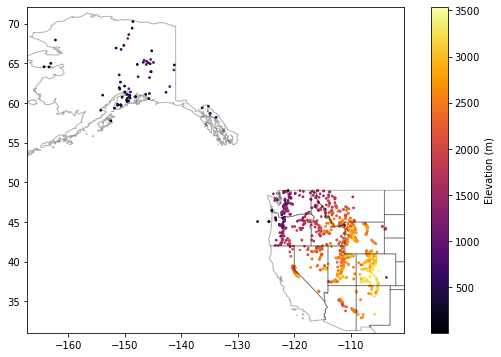

In [19]:
f, ax = plt.subplots(figsize=(10,6))
sites_gdf_all.plot(ax=ax, column='elevation_m', markersize=3, cmap='inferno', legend=True, legend_kwds={'label': "Elevation (m)"})
#This prevents matplotlib from updating the axes extent (states polygons cover larger area than SNOTEL points)
ax.autoscale(False)
states_gdf.plot(ax=ax, facecolor='none', edgecolor='k', alpha=0.3);

### Exclude the Alaska (AK) points to isolate points over Western U.S.
* Simple appraoch is to remove points where the site name contains 'AK' with attribute filter
* Note the number of records

In [ ]:
sites_gdf_conus = sites_gdf_all[~(sites_gdf_all.index.str.contains('AK'))]

* Alternatively, can use a spatial filter (see GeoPandas `cx` indexer functionality for a bounding box)

In [ ]:
#xmin, xmax, ymin, ymax = [-126, 102, 30, 50]
#sites_gdf_conus = sites_gdf_all.cx[xmin:xmax, ymin:ymax]

In [ ]:
sites_gdf_conus.shape

### Update your scatterplot as sanity check
* Should look something like the Western U.S.

In [ ]:
f, ax = plt.subplots(figsize=(10,6))
sites_gdf_conus.plot(ax=ax, column='elevation_m', markersize=3, cmap='inferno', legend=True, legend_kwds={'label': "Elevation (m)"})
ax.autoscale(False)
states_gdf.plot(ax=ax, facecolor='none', edgecolor='k', alpha=0.3);

### Export SNOTEL site GeoDataFrame as a geojson
* Maybe useful for other purposes, and can avoid all of the above processing, just load directly with geopandas `read_file`

In [ ]:
sites_gdf_conus.to_file?

In [ ]:
sites_fn = 'snotel_conus_sites.json'
if not os.path.exists(sites_fn):
    sites_gdf_conus.to_file(sites_fn, driver='GeoJSON')

## Part 2: Spatial filter points by polygon

### Load Grand Mesa Polygon

In [ ]:
gm_poly_fn = 'grand_mesa_poly.geojson'

In [ ]:
gm_poly_gdf = gpd.read_file(gm_poly_fn)

In [ ]:
gm_poly_gdf.plot()

## A quick aside on `geometry` objects

### Vector data contain `geometry` objects
* Classes (Point, Line, Polygon) with unique attribute and methods
* Polygon vs. MultiPolygon
* https://automating-gis-processes.github.io/site/notebooks/L1/geometric-objects.html
* https://shapely.readthedocs.io/en/stable/manual.html#geometric-objects

![Geometry types](https://datacarpentry.org/organization-geospatial/fig/dc-spatial-vector/pnt_line_poly.png)
Image Source: National Ecological Observatory Network (NEON), from https://datacarpentry.org/organization-geospatial

### Isolate Polygon geometry within GeoDataFrame

In [ ]:
type(gm_poly_gdf)

In [ ]:
gm_poly_gdf

In [ ]:
gm_poly_gdf.total_bounds

In [ ]:
gm_poly_gdf.iloc[0] #Now a GeoSeries

In [ ]:
gm_poly_geom = gm_poly_gdf.iloc[0].geometry
gm_poly_geom

In [ ]:
print(gm_poly_geom)

In [ ]:
list(gm_poly_geom.exterior.coords)

In [ ]:
gm_poly_geom.bounds

### Generate boolean index for points that intersect the polygon
* This will return a new GeoDataSeries with True/False values for each record

In [ ]:
idx = sites_gdf_all.intersects(gm_poly_geom)

In [ ]:
idx.head()

In [ ]:
idx.value_counts()

### Use fancy indexing to isolate points and return new GeoDataFrame

In [ ]:
gm_snotel_sites = sites_gdf_all.loc[idx]

In [ ]:
gm_snotel_sites

### Quick plot

In [ ]:
f, ax = plt.subplots(figsize=(10,6))
gm_snotel_sites.plot(ax=ax, column='elevation_m', markersize=20, edgecolor='k', cmap='inferno', \
                  legend=True, legend_kwds={'label':'Elevation (m)'})
#ctx.add_basemap(ax=ax, crs=gm_snotel_sites.crs, source=ctx.providers.Stamen.Terrain)
ax.set_title('Grand Mesa SNOTEL Stations');

In [ ]:
import hvplot.pandas
from geoviews import tile_sources as gvts

In [ ]:
gm_snotel_sites.hvplot(hover_cols=['index','name']) * gm_poly_gdf.to_crs(gm_snotel_sites.crs).hvplot(color='none')

### Add a basemap
This functionality will add a publicly available tiled basemap to your interactive holoviews plot, which is useful for context during interactive visualization.

Note that we need to reproject our GeoDataframe to match the CRS of the tiled basemap here.

For static plots with matplotlib (e.g., for publication) can also use `contextily` for this https://contextily.readthedocs.io/en/latest/

In [ ]:
map_tiles = gvts.EsriImagery

In [ ]:
map_tiles * gm_snotel_sites.to_crs('EPSG:3857').hvplot(hover_cols=['index','name']) * \
gm_poly_gdf.to_crs('EPSG:3857').hvplot(color='none')

## Part 3: Time series analysis for one station
Now that we've identified sites of interest, let's query the API to obtain the time series data for variables of interest (snow!).

https://wcc.sc.egov.usda.gov/nwcc/site?sitenum=622&state=co

In [ ]:
sitecode = gm_snotel_sites.index[-1]
sitecode

### Get available measurements for this site
Note that there are many standard meteorological variables that can be downloaded for this site, in addition to the snow depth and snow water equivalent.

In [ ]:
ulmo.cuahsi.wof.get_site_info(wsdlurl, sitecode)['series'].keys()

* _H = "hourly"
* _D = "daily"
* _sm, _m = "monthly"

### Let's consider the 'SNOTEL:SNWD_D' variable (Daily Snow Depth)
* Assign 'SNOTEL:SNWD_D' to a variable named `variablecode`
* Get some information about the variable using `get_variable_info` method
    * Note the units, nodata value, etc.
* **Note: The snow depth records are almost always shorter/noisier than the SWE records for SNOTEL sites**

In [ ]:
#Daily SWE
#variablecode = 'SNOTEL:WTEQ_D'
#Daily snow depth
variablecode = 'SNOTEL:SNWD_D'

In [ ]:
#Hourly SWE
#variablecode = 'SNOTEL:WTEQ_H'
#Hourly snow depth
#variablecode = 'SNOTEL:SNWD_H'

In [ ]:
ulmo.cuahsi.wof.get_variable_info(wsdlurl, variablecode)

### Define a function to fetch data
* I've done this for you, but please review the comments and steps to see what is going on under the hood
* You'll probably have to do similar data wrangling for another project at some point in the future

In [ ]:
#Get current datetime
today = datetime.today().strftime('%Y-%m-%d')

def snotel_fetch(sitecode, variablecode='SNOTEL:SNWD_D', start_date='1950-10-01', end_date=today):
    #print(sitecode, variablecode, start_date, end_date)
    values_df = None
    try:
        #Request data from the server
        site_values = ulmo.cuahsi.wof.get_values(wsdlurl, sitecode, variablecode, start=start_date, end=end_date)
        #Convert to a Pandas DataFrame   
        values_df = pd.DataFrame.from_dict(site_values['values'])
        #Parse the datetime values to Pandas Timestamp objects
        values_df['datetime'] = pd.to_datetime(values_df['datetime'], utc=True)
        #Set the DataFrame index to the Timestamps
        values_df = values_df.set_index('datetime')
        #Convert values to float and replace -9999 nodata values with NaN
        values_df['value'] = pd.to_numeric(values_df['value']).replace(-9999, np.nan)
        #Remove any records flagged with lower quality
        values_df = values_df[values_df['quality_control_level_code'] == '1']
    except:
        print("Unable to fetch %s" % variablecode)

    return values_df

### Use this function to get the full 'SNOTEL:SNWD_D' record for one station
* Inspect the results
* We used a dummy start date of Jan 1, 1950.  What is the actual the first date returned?

In [ ]:
#Get all records, can filter later
start_date = datetime(1950,1,1)
end_date = datetime.today()

In [ ]:
print(sitecode)
values_df = snotel_fetch(sitecode, variablecode, start_date, end_date)
values_df.shape

In [ ]:
values_df.head()

In [ ]:
#Get number of decimal years between first and last observation
nyears = (values_df.index.max() - values_df.index.min()).days/365.25
nyears

### Create a quick plot to view the time series
* Take a moment to inspect the `value` column, which is where the `SNWD_D` values are stored
* Sanity check thought question: *What are the units again?*

In [ ]:
values_df.hvplot()

### Compute the integer day of year (doy) and integer day of water year (dowy)
* Can get doy for each record with `df.index.dayofyear`
    * Can compute on the fly, but add a new column to store these values
    * https://pandas.pydata.org/pandas-docs/version/0.19/generated/pandas.DatetimeIndex.dayofyear.html
* For the day of water year, you'll need to offset by 9 months, then compute day of year
    * https://en.wikipedia.org/wiki/Water_year
    * Add another column to store these values

In [ ]:
#Add DOY and DOWY column
#Need to revisit for leap year support
def add_dowy(df, col=None):
    if col is None:
        df['doy'] = df.index.dayofyear
    else:
        df['doy'] = df[col].dayofyear
    # Sept 30 is doy 273
    df['dowy'] = df['doy'] - 273
    df.loc[df['dowy'] <= 0, 'dowy'] += 365

In [ ]:
add_dowy(values_df)

### Compute statistics for each day of the water year, using values from all years
* Seems like a Pandas groupby/agg might work here
* Stats should at least include min, max, mean, and median

In [ ]:
stat_list = ['count','min','max','mean','std','median','mad']

In [ ]:
doy_stats = values_df.groupby('dowy').agg(stat_list)['value']
doy_stats

### Create a plot of these aggregated dowy values
* Something like the 30-year mean and median here: https://www.nwrfc.noaa.gov/snow/plot_SWE.php?id=AFSW1

In [ ]:
f,ax = plt.subplots(figsize=(10,5))

for stat in ['min','max','mean','median']:
    ax.plot(doy_stats.index, doy_stats[stat], label=stat)

ax.fill_between(doy_stats.index, doy_stats['mean'] - doy_stats['std'], doy_stats['mean'] + doy_stats['std'], \
                color='lightgrey', label='1-std')

title = f'{sitecode}: \n{values_df.index.min().date()} to {values_df.index.max().date()} ({nyears:.2f} years)'

ax.set_title(title)
ax.set_xlabel('Day of Water Year (Oct 1)')
ax.set_ylabel('Snow depth (in)')
ax.grid()
ax.legend()
ax.set_xlim(0,366)
ax.set_ylim(bottom=0);

### Add the daily snow depth values for the current water year
* Can use pandas indexing here with simple strings ('YYYY-MM-DD'), or Timestamp objects
    * Standard slicing also works with `:`
* Make sure to `dropna` to remove any records missing data
* Add this to your plot

In [ ]:
#Define variable to store current year
curr_y = datetime.now().year
curr_y

In [ ]:
#df_wy = values_df.loc['2019-10-1':].dropna()
df_wy = values_df.loc[f'{curr_y-1}-10-1':].dropna()

In [ ]:
f,ax = plt.subplots(figsize=(10,5))
for stat in ['min','max','mean','median']:
    ax.plot(doy_stats.index, doy_stats[stat], label=stat)

ax.fill_between(doy_stats.index, doy_stats['mean'] - doy_stats['std'], doy_stats['mean'] + doy_stats['std'], \
                color='lightgrey', label='1-std')

ax.set_title(title)
ax.set_xlabel('Day of Water Year')
ax.set_ylabel('Snow depth (in)')
ax.grid()
ax.plot(df_wy['dowy'], df_wy['value'], marker='.', color='k', ls='none', label='Current WY')
ax.legend()
ax.set_xlim(0,366)
ax.set_ylim(bottom=0);

### What was the percentage of "normal" snow depth on April 1 of this year?
* Can use long-term median for this dowy

In [ ]:
df_wy.loc[f'{curr_y}-4-1']

In [ ]:
apr1_doy = df_wy.loc[f'{curr_y}-4-1']['dowy']
apr1_doy

In [ ]:
doy_stats.loc[apr1_doy]

In [ ]:
#Percent of normal
perc_normal = 100 * df_wy.loc[f'{curr_y}-4-1']['value']/doy_stats.loc[apr1_doy]['median']
print(f'{perc_normal:0.2f}% percent of normal snow depth on DOWY {apr1_doy} in {curr_y}')

### Index DataFrame by date or date range
* Maybe useful for project work

In [ ]:
dt1 = '2017-2-1'
dt2 = '2017-2-4'

In [ ]:
#Single date
values_df.loc[dt1]

In [ ]:
values_df.loc[dt1]['value']

In [ ]:
values_df.loc[dt1:dt2]

### Query multiple sites
* Can use a loop to query multiple sites and/or variables

In [ ]:
#Define an empty dictionary to store returns for each site
value_dict = {}
for i, sitecode in enumerate(gm_snotel_sites.index):
    print('%i of %i sites: %s' % (i+1, len(gm_snotel_sites.index), sitecode))
    out = snotel_fetch(sitecode, variablecode)
    if out is not None:
        value_dict[sitecode] = out['value']
#Convert the dictionary to a DataFrame, automatically handles different datetime ranges (nice!)
multi_df = pd.DataFrame.from_dict(value_dict)

In [ ]:
multi_df

In [ ]:
multi_df.hvplot()

In [ ]:
#Hack to remove bad measurements
multi_df[multi_df > 190] = np.nan

In [ ]:
multi_df.hvplot()

### Scatterplot to compare corresponding values

In [ ]:
multi_df.dropna().hvplot(kind='scatter', x='SNOTEL:622_CO_SNTL', y='SNOTEL:682_CO_SNTL', \
                         aspect='equal', s=1)

### Determine Pearson's correlation coefficient for the two time series
* https://en.wikipedia.org/wiki/Pearson_correlation_coefficient
* See the Pandas `corr` method
    * This should properly handle nan under the hood!

In [ ]:
multi_df.corr()

Highly correlated snow depth records for these two sites!

## Summary